In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# line_plots_from_runs_multi_root.py
import os, re, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---------- defaults ----------
DEFAULT_LAMBDAS = (1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8)
DEFAULT_ALPHAS  = (0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100,  1e3, 1e5, 1e6, 1e7, 1e8)
DEFAULT_M0S     = (0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1)

# ---------- robust dir helpers (closest numeric match) ----------
_num_pat = re.compile(r"([0-9eE\.\-]+)$")

def _closest_dir_by_number(parent: Path, prefix: str, target: float):
    if not parent.exists():
        return None
    cands = [d for d in parent.iterdir() if d.is_dir() and d.name.startswith(prefix + "_")]
    if not cands:
        return None
    def take_num(p: Path):
        m = _num_pat.search(p.name)
        return float(m.group(1)) if m else None
    pairs = [(p, take_num(p)) for p in cands]
    pairs = [(p, v) for p, v in pairs if v is not None]
    if not pairs:
        return None
    return min(pairs, key=lambda pv: abs(pv[1] - float(target)))[0]

def _summary_speed(p: Path, which="N"):
    if p is None:
        return np.nan
    s = p / "summary.json"
    if not s.exists():
        return np.nan
    try:
        meta = json.loads(s.read_text())
        # accept several keys
        keys = ("wave_speed", "speed", "c") if which.upper()=="N" else ("m_wave_speed","wave_speed","speed","c")
        for k in keys:
            if k in meta and meta[k] is not None and np.isfinite(meta[k]):
                return float(meta[k])
    except Exception:
        pass
    return np.nan

# ----- finders that try multiple base roots and return first hit -----
def _find_plain_dir_multi(roots, lam, m0):
    for root in roots:
        base = Path(root)
        lam_dir = _closest_dir_by_number(base, "lambda", lam)
        if lam_dir is None: 
            continue
        m_dir = _closest_dir_by_number(lam_dir, "m0", m0)
        if m_dir is not None:
            return m_dir
    return None

def _find_source_dir_multi(roots, fixed_lambda, alpha, m0):
    for root in roots:
        base = Path(root)
        lam_dir = _closest_dir_by_number(base, "lambda", fixed_lambda)
        if lam_dir is None:
            continue
        a_dir = _closest_dir_by_number(lam_dir, "alpha", alpha)
        if a_dir is None:
            continue
        m_dir = _closest_dir_by_number(a_dir, "m0", m0)
        if m_dir is not None:
            return m_dir
    return None

# ---------- main line-plotter ----------
def plot_speed_vs_log_param_lines(
    *,
    # WHAT to sweep
    param="alpha",                                  # "alpha" or "lambda"
    base_dirs=("speeds_func_l", "speeds_func_m"),   # can be one or many roots
    param_values=None,                              # defaults set below
    m0_vals=DEFAULT_M0S,
    fixed_lambda=0.1,                               # used when param="alpha"

    # styling
    title=None,
    xlabel=None,
    ylabel="Numerically estimated wave speed",
    cmap_name="plasma",
    ms=6, lw=2.5,
    tick_fs=13, label_fs=16, title_fs=20, legend_fs=12,

    # behavior
    warn_missing=True,
    save=False, outpath=None
):
    """
    Draw line plot: speed vs log10(param), one curve per m0.
    Looks across multiple roots and uses closest numeric directory matches.
    """

    # normalize inputs
    if isinstance(base_dirs, (str, Path)):
        base_dirs = (base_dirs,)
    base_dirs = tuple(str(Path(b)) for b in base_dirs)

    if param_values is None:
        param_values = DEFAULT_ALPHAS if param == "alpha" else DEFAULT_LAMBDAS

    pvals = np.asarray(param_values, float)
    logx  = np.log10(pvals)

    fig, ax = plt.subplots(figsize=(10, 6))
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / max(1, len(m0_vals)-1)) for i in range(len(m0_vals))]

    missing = 0
    for k, m0 in enumerate(m0_vals):
        ys = []
        for v in pvals:
            if param == "alpha":
                m_dir = _find_source_dir_multi(base_dirs, fixed_lambda, v, m0)
                label_root = f"lambda_{fixed_lambda}"
                label_param = f"alpha_{v}"
            else:
                m_dir = _find_plain_dir_multi(base_dirs, v, m0)
                label_root = None
                label_param = f"lambda_{v}"

            c = _summary_speed(m_dir, which="N")
            if not np.isfinite(c):
                ys.append(np.nan)
                if warn_missing:
                    where = (label_root + "/") if label_root else ""
                    print(f"[warn] missing speed for m0_{m0} under {where}{label_param} (searched {len(base_dirs)} roots)")
                missing += 1
            else:
                ys.append(c)

        ys = np.asarray(ys, float)
        ax.plot(logx, ys, "-o", color=colors[k], lw=lw, ms=ms, label=rf"{m0:g}")

    # labels/titles
    if xlabel is None:
        xlabel = r"$\log_{10}(\alpha)$" if param=="alpha" else r"$\log_{10}(\lambda)$"
    ax.set_xlabel(xlabel, fontsize=label_fs)
    ax.set_ylabel(ylabel, fontsize=label_fs)

    if title is None:
        title = r"Initial value of ECM $(m_0)$ vs $\alpha$" if param=="alpha" \
                else r"Initial value of ECM $(m_0)$ vs $\lambda$"
    ax.set_title(title, fontsize=title_fs)

    ax.tick_params(axis="both", labelsize=tick_fs)
    ax.grid(True, linestyle="--", alpha=0.25)

    ax.legend(
        title=r"$m_0$", fontsize=legend_fs, title_fontsize=legend_fs,
        loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True
    )
    fig.tight_layout(rect=[0, 0, 0.85, 1])

    if save:
        if outpath is None:
            name = f"speed_vs_log_{param}.png"
            outpath = Path(base_dirs[0]) / name
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

    if missing and warn_missing:
        print(f"[info] missing/NaN points: {missing}")
    return fig, ax

[warn] missing speed for m0_0 under lambda_0.1/alpha_100000.0 (searched 2 roots)
[warn] missing speed for m0_0 under lambda_0.1/alpha_1000000.0 (searched 2 roots)
[warn] missing speed for m0_0 under lambda_0.1/alpha_10000000.0 (searched 2 roots)
[warn] missing speed for m0_0 under lambda_0.1/alpha_100000000.0 (searched 2 roots)


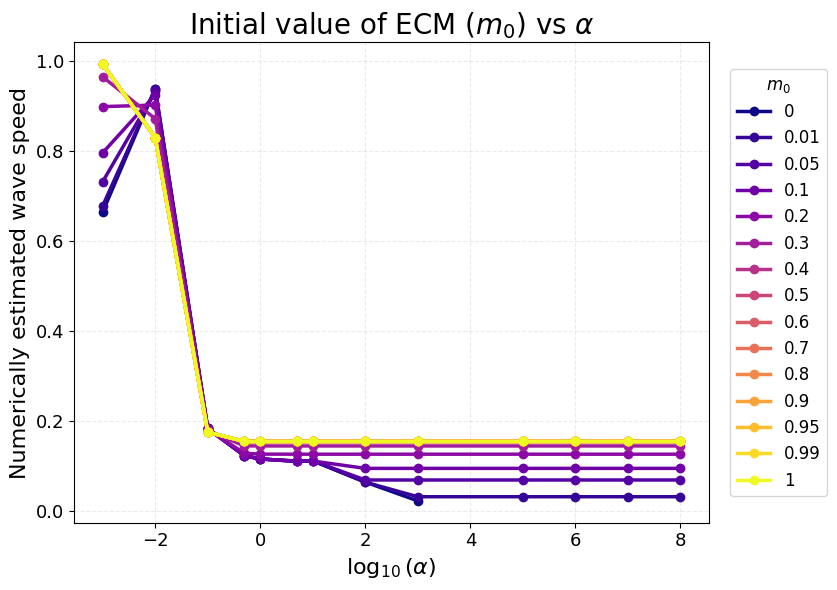

[info] missing/NaN points: 4


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Initial value of ECM $(m_0)$ vs $\\alpha$'}, xlabel='$\\log_{10}(\\alpha)$', ylabel='Numerically estimated wave speed'>)

In [3]:
plot_speed_vs_log_param_lines(
    param="alpha",
    base_dirs=("speeds_func_l", "speeds_func_u"),  # both roots
    fixed_lambda=0.1                                # because your tree is lambda_0.1/alpha_*/m0_*
)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lambda_lines_by_m0_for_fixed_alpha(
    base_dirs=("speeds_func_l", "speeds_func_m"),
    alpha=0.1,                                      # <-- fixed α
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
             0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100,
                 1e3, 1e5, 1e6, 1e7, 1e8),
    which_speed="N",
    cmap="plasma",
    lw=2.5, ms=6,
    tick_fs=13, label_fs=16, title_fs=20, legend_fs=12,
    warn_missing=True,
    save=False, outpath=None
):
    """
    Plot wave speed vs log10(lambda) at a fixed alpha, with one curve per m0.
    Requires `_merge_speed_from_roots(base_dirs, lam, alpha, m0, which)` to be defined
    (same helper you used in the heatmap code).
    """
    lambdas = np.asarray(lambda_vals, float)
    log_lambda = np.log10(lambdas)

    cmap_obj = plt.get_cmap(cmap)
    colors = [cmap_obj(i / max(1, len(m0_vals)-1)) for i in range(len(m0_vals))]

    fig, ax = plt.subplots(figsize=(10, 6))

    total_missing = 0
    for k, m0 in enumerate(m0_vals):
        ys = []
        for lam in lambdas:
            cval = _merge_speed_from_roots(base_dirs, lam, alpha, m0, which=which_speed)
            ys.append(cval)
            if warn_missing and not np.isfinite(cval):
                print(f"[warn] missing speed: α={alpha:g}, m0={m0:g}, λ={lam:g}")
                total_missing += 1
        ys = np.asarray(ys, float)
        ax.plot(log_lambda, ys, "-o", color=colors[k], lw=lw, ms=ms, label=rf"{m0:g}")

    ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
    ax.set_ylabel("Numerically estimated wave speed", fontsize=label_fs)
    ax.set_title(rf"Wave speed vs $\lambda$ at $\alpha={alpha:g}$", fontsize=title_fs)
    ax.tick_params(axis="both", labelsize=tick_fs)
    ax.grid(True, linestyle="--", alpha=0.3)

    # legend on the right
    ax.legend(title=r"$m_0$", fontsize=legend_fs, title_fontsize=legend_fs,
              loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True)
    fig.tight_layout(rect=[0, 0, 0.85, 1])

    if save:
        if outpath is None:
            outpath = f"speed_vs_loglambda_alpha_{alpha:g}.png"
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

    if warn_missing and total_missing:
        print(f"[info] total missing/NaN points: {total_missing}")

    return fig, ax

NameError: name '_merge_speed_from_roots' is not defined

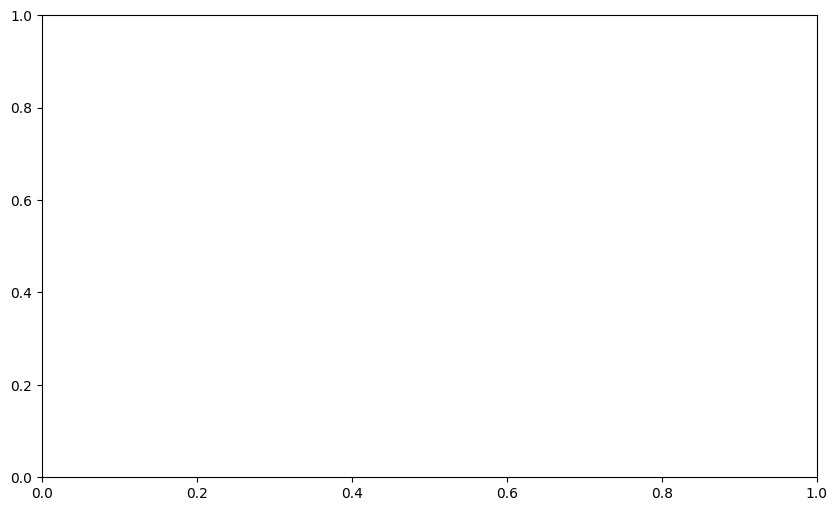

In [5]:
# Curves for many m0’s, at α = 0.1
plot_lambda_lines_by_m0_for_fixed_alpha(
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alpha=0.1,
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    save=True,
    cmap = 'viridis'
)

In [ ]:
import os, json, re
import numpy as np
import matplotlib.pyplot as plt

# ---------- format EXACTLY like your runner saved ----------
def _fmt_val(v):
    """Format numbers to match your folder names (e.g., 10 not 10.0, 0.01, 1e6)."""
    if isinstance(v, (int, np.integer)) or (isinstance(v, float) and v.is_integer()):
        return f"{int(v)}"
    s = f"{v}"
    return s.rstrip('0').rstrip('.') if '.' in s else s

def _alpha_title(a):
    """Pretty α labels: 1 → α=1, 10 → α=10, powers of 10 → α=10^{k}."""
    if a == 1:
        return r"$\alpha = 1$"
    if a == 10:
        return r"$\alpha = 10$"
    log10a = np.log10(a)
    if np.isclose(log10a, round(log10a), atol=1e-9):
        return r"$\alpha = 10^{%d}$" % int(round(log10a))
    return r"$\alpha = %g$" % a

# ---------- exact path helpers (no 'closest'!) ----------
def _exact_dir(parent, prefix, value):
    """Return path 'parent/prefix_value' if it exists, else None."""
    path = os.path.join(parent, f"{prefix}_{_fmt_val(value)}")
    return path if os.path.isdir(path) else None

def _run_dir_exact(root, lam, alpha, m0):
    """Exact: root/lambda_*/alpha_*/m0_*."""
    lam_dir = _exact_dir(root, "lambda", lam)
    if lam_dir is None: return None
    a_dir   = _exact_dir(lam_dir, "alpha", alpha)
    if a_dir is None:   return None
    m_dir   = _exact_dir(a_dir, "m0", m0)
    return m_dir

def _load_speed(run_dir, which="N"):
    """Read speed from summary.json; returns NaN if missing."""
    if run_dir is None: return np.nan
    s = os.path.join(run_dir, "summary.json")
    if not os.path.exists(s): return np.nan
    try:
        with open(s, "r") as f:
            meta = json.load(f)
        key = "wave_speed" if which.upper() == "N" else "m_wave_speed"
        val = meta.get(key, None)
        return float(val) if val is not None else np.nan
    except Exception:
        return np.nan

def _merge_speed_from_roots(roots, lam, alpha, m0, which="N"):
    """Try each base_dir with EXACT path; first hit wins."""
    for root in roots:
        rd = _run_dir_exact(root, lam, alpha, m0)
        val = _load_speed(rd, which=which)
        if np.isfinite(val):
            return val
    return np.nan

# ---------- grid plotter (per-panel colorbars) ----------
def plot_wavespeed_alpha_grid(
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alpha_rows=((1e-3, 1e-2, 1e-1), (1e3, 1e4, 1e5)),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8),
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    which_speed="N",
    cmap="plasma",
    levels=20,
    fig_size=(18, 9),
    # ---- unified font control ----
    font_scale=1.0,   # master knob: 1.0=default, 1.2=+20%, 0.9=-10%, etc.
    tick_fs=None,     # if None, uses 11*font_scale
    label_fs=None,    # if None, uses 14*font_scale
    title_fs=None,    # if None, uses 16*font_scale
    cbar_fs=None,     # if None, uses 12*font_scale
    suptitle=None,    # main title; None = default title
    debug=False
):
    """
    Draw a grid of wavespeed heatmaps vs λ (x) and m0 (y) for multiple α values.

    Font sizes:
      - Set 'font_scale' to scale all text at once (ticks, labels, titles, colorbars).
      - Optionally override any of tick_fs/label_fs/title_fs/cbar_fs directly.
    """
    # Resolve fonts from the single knob unless explicitly overridden
    tick_fs  = int(round((tick_fs  if tick_fs  is not None else 11) * font_scale))
    label_fs = int(round((label_fs if label_fs is not None else 14) * font_scale))
    title_fs = int(round((title_fs if title_fs is not None else 16) * font_scale))
    cbar_fs  = int(round((cbar_fs  if cbar_fs is not None else 12) * font_scale))
    suptitle_text = suptitle if suptitle is not None else r"Wavespeed heatmaps vs $\lambda$ and $m_0$ across $\alpha$"

    base_dirs   = tuple(os.path.abspath(b) for b in base_dirs)
    alpha_rows  = tuple(tuple(float(a) for a in row) for row in alpha_rows)
    m0_vals     = np.asarray(m0_vals, dtype=float)
    lambda_vals = np.asarray(lambda_vals, dtype=float)

    X, Y = np.meshgrid(np.log10(lambda_vals), m0_vals)

    # Precompute H per panel (EXACT lookups)
    H_mats = []
    for row in alpha_rows:
        row_mats = []
        for alpha in row:
            H = np.full((len(m0_vals), len(lambda_vals)), np.nan, dtype=float)
            for i, m0 in enumerate(m0_vals):
                for j, lam in enumerate(lambda_vals):
                    val = _merge_speed_from_roots(base_dirs, lam, alpha, m0, which=which_speed)
                    H[i, j] = val
                    if debug:
                        print(f"root=* exact, α={alpha:g}, m0={m0:g}, λ={lam:g} -> {val}")
            row_mats.append(H)
        H_mats.append(row_mats)

    nrows, ncols = len(alpha_rows), len(alpha_rows[0])
    fig, axes = plt.subplots(nrows, ncols, figsize=fig_size, constrained_layout=True, squeeze=False)

    for r in range(nrows):
        for c in range(ncols):
            ax = axes[r, c]
            H  = H_mats[r][c]
            Hm = np.ma.masked_invalid(H)

            # Per-panel autoscale (each α gets its own range)
            if np.isfinite(Hm).any():
                vmin, vmax = float(np.nanmin(Hm)), float(np.nanmax(Hm))
                if vmin == vmax: vmax = vmin + 1e-9
            else:
                vmin, vmax = 0.0, 1.0

            cf = ax.contourf(X, Y, Hm, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)

            # Per-panel colorbar
            cbar = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=cbar_fs)
            cbar.set_label("Estimated wave speed", fontsize=cbar_fs)

            ax.set_title(_alpha_title(alpha_rows[r][c]), fontsize=title_fs)

            # Axes labeling
            if r == nrows - 1:
                ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
            else:
                ax.set_xticklabels([])

            if c == 0:
                ax.set_ylabel(r"$m_0$", fontsize=label_fs)
            else:
                ax.set_yticklabels([])

            # Decade ticks along x
            decades = np.unique(np.floor(np.log10(lambda_vals)).astype(int))
            ax.set_xticks(decades)
            ax.set_xticklabels([f"{d:d}" for d in decades], fontsize=tick_fs)
            ax.tick_params(axis="y", labelsize=tick_fs)

    fig.suptitle(suptitle_text, fontsize=label_fs + int(round(10 * font_scale)))
    plt.show()
    return fig, axes

In [6]:
fig, axes = plot_wavespeed_alpha_grid(
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alpha_rows=((1e-3, 1e-2, 1e-1), (1, 10, 100), (1e3, 1e4, 1e5)),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8),
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    cmap="viridis",
    font_scale=1.25,
    
)

NameError: name 'plot_wavespeed_alpha_grid' is not defined

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def _latex_pow10(val, tol=1e-10):
    if val <= 0:
        return f"{val:g}"
    log10v = np.log10(val)
    k = int(round(log10v))
    if abs(log10v - k) < tol:
        return rf"10^{{{k}}}"
    a = val / (10.0 ** k)
    return rf"{a:.2g}\times 10^{{{k}}}"

def plot_lambda_lines_by_m0_grid(
    *,
    base_dirs=("speeds_func_l", "speeds_func_m"),
    alphas=(1e-3, 10.0, 1e8),                 # pass 4 alphas for a 1x4 grid, etc.
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
             0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100,
                 1e3, 1e4, 1e5, 1e6, 1e7, 1e8),
    which_speed="N",
    cmap_name="plasma",
    lw=2.5, ms=5,
    # ---- unified font control (new) ----
    font_scale=1.0,    # master knob: 1.0 default, 1.1 +10%, 0.9 -10%, etc.
    tick_fs=None,      # if None -> 12 * font_scale
    label_fs=None,     # if None -> 15 * font_scale
    title_fs=None,     # if None -> 17 * font_scale
    legend_fs=None,    # if None -> 12 * font_scale
    # -----------------------------------
    sharey=True,
    warn_missing=True,
    legend_anchor=0.90,   # how close the legend sits (0.90–0.95 is nice)
    save=False, outpath=None
):
    """
    Row of subplots (1×N). Each panel: wave speed vs log10(lambda) at a fixed alpha,
    with one curve per m0. Requires `_merge_speed_from_roots(base_dirs, lam, alpha, m0, which)`.
    """

    # ---- resolve font sizes from single knob unless overridden ----
    _tick_fs   = int(round((tick_fs   if tick_fs   is not None else 12) * font_scale))
    _label_fs  = int(round((label_fs  if label_fs  is not None else 15) * font_scale))
    _title_fs  = int(round((title_fs  if title_fs  is not None else 17) * font_scale))
    _legend_fs = int(round((legend_fs if legend_fs is not None else 12) * font_scale))

    # normalize roots
    if isinstance(base_dirs, (str, Path)):
        base_dirs = (base_dirs,)
    base_dirs = tuple(str(Path(b)) for b in base_dirs)

    alphas   = tuple(float(a) for a in alphas)
    ncols    = len(alphas)
    lambdas  = np.asarray(lambda_vals, float)
    loglam   = np.log10(lambdas)

    # consistent colors across panels (by m0)
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / max(1, len(m0_vals)-1)) for i in range(len(m0_vals))]

    # figure width scales with number of panels (also scale a bit with fonts)
    fig_width = max(5.0 * ncols, 8.0) * (0.95 + 0.1 * (font_scale - 1.0))
    fig, axes = plt.subplots(1, ncols, figsize=(fig_width, 5.0 * font_scale), sharey=sharey)
    if ncols == 1:
        axes = [axes]

    total_missing = 0
    handles_one = None

    for p, alpha in enumerate(alphas):
        ax = axes[p]
        panel_handles = []
        for k, m0 in enumerate(m0_vals):
            ys = []
            for lam in lambdas:
                cval = _merge_speed_from_roots(base_dirs, lam, alpha, m0, which=which_speed)
                ys.append(cval)
                if warn_missing and not np.isfinite(cval):
                    total_missing += 1
            ys = np.asarray(ys, float)
            h = ax.plot(loglam, ys, "-o", color=colors[k], lw=lw, ms=ms, label=rf"{m0:g}")[0]
            panel_handles.append(h)

        # pretty alpha title as power of 10
        if alpha == 10:
            ax.set_title(rf"$\alpha=10$", fontsize=_title_fs)
        elif alpha == 1:
            ax.set_title(rf"$\alpha=1$", fontsize=_title_fs)
        else:
            a_tex = _latex_pow10(alpha)
            ax.set_title(rf"$\alpha={a_tex}$", fontsize=_title_fs)

        ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=_label_fs)
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.tick_params(axis="both", labelsize=_tick_fs)

        # decade ticks on x
        decades = np.unique(np.floor(np.log10(lambdas)).astype(int))
        ax.set_xticks(decades)
        ax.set_xticklabels([f"{d:d}" for d in decades], fontsize=_tick_fs)

        if p == 0:
            ax.set_ylabel("Numerically estimated wave speed", fontsize=_label_fs)

        if handles_one is None:  # stash once for global legend
            handles_one = panel_handles

    # global legend on the right, closer via legend_anchor
    fig.legend(
        handles_one, [h.get_label() for h in handles_one],
        title=r"$m_0$", fontsize=_legend_fs, title_fontsize=_legend_fs,
        loc="center left", bbox_to_anchor=(legend_anchor, 0.5), frameon=True
    )
   
    fig.suptitle(r"Initial value of ECM $(m_0)$ vs $\lambda$", fontsize=_title_fs + 2, y=.91)
    # give a bit more right margin for legend
    fig.tight_layout(rect=[0, 0, min(0.92, legend_anchor - 0.02), 0.95])

    if save:
        if outpath is None:
            outpath = f"speed_vs_lambda_by_m0_alpha_grid_{ncols}cols.png"
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

    return fig, axes

NameError: name '_merge_speed_from_roots' is not defined

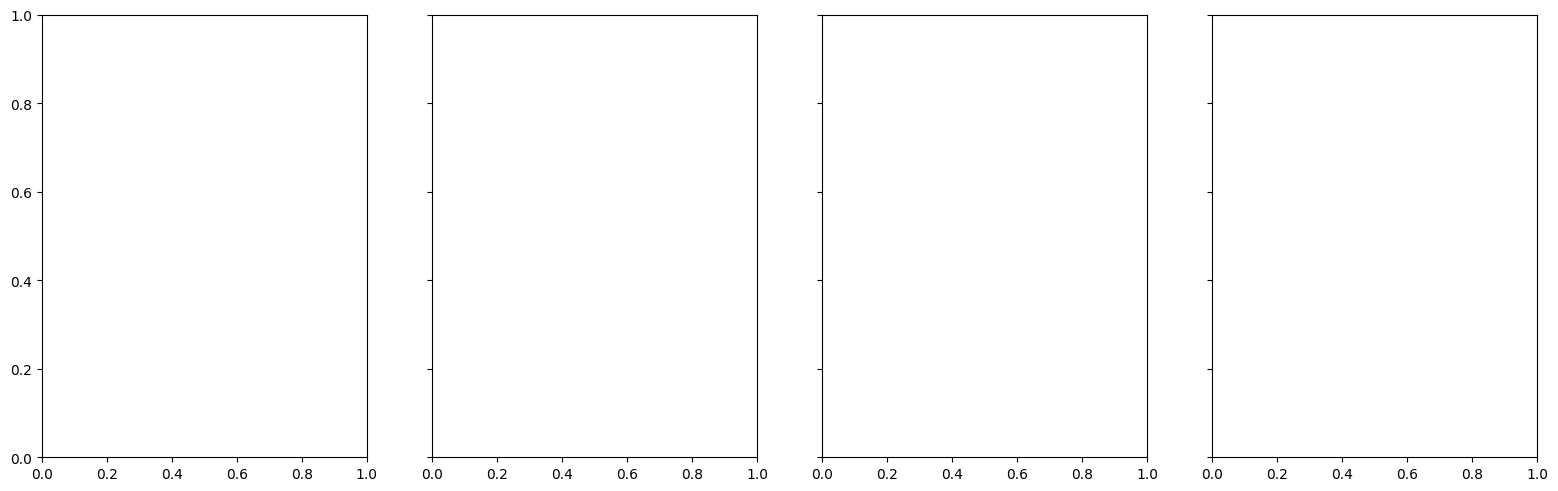

In [8]:
plot_lambda_lines_by_m0_grid(
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alphas=(1e-3, 1e-1, 1e3, 1e6),
    font_scale=1.15,
    legend_anchor=0.90,
    save=True
)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path

# --- assumes you have _merge_speed_from_roots(...) in scope ---

def _nanfilter(*arrs):
    mask = np.ones_like(np.asarray(arrs[0]), dtype=bool)
    for a in arrs:
        a = np.asarray(a)
        mask &= np.isfinite(a)
    return [np.asarray(a)[mask] for a in arrs]

def _build_speed_grid_for_m0(*, base_dirs, alphas, lambda_vals, m0, which_speed="N", warn_missing=True):
    if isinstance(base_dirs, (str, Path)):
        base_dirs = (base_dirs,)
    base_dirs = tuple(str(Path(b)) for b in base_dirs)

    A, L = len(alphas), len(lambda_vals)
    C = np.full((A, L), np.nan, float)
    missing = 0
    for i, a in enumerate(alphas):
        for j, lam in enumerate(lambda_vals):
            cval = _merge_speed_from_roots(base_dirs, float(lam), float(a), float(m0), which=which_speed)
            C[i, j] = cval
            if warn_missing and not np.isfinite(cval):
                missing += 1
    return C

def _flatten_samples(lambdas, alphas, C):
    """Return flat arrays lam_s, alp_s, c_s from grids."""
    L = len(lambdas); A = len(alphas)
    lam_grid = np.broadcast_to(np.asarray(lambdas)[None, :], (A, L))
    alp_grid = np.broadcast_to(np.asarray(alphas)[:, None], (A, L))
    return lam_grid.ravel(), alp_grid.ravel(), np.asarray(C).ravel()

def plot_speed_scatter_compare_by_m0(
    *,
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alphas=(1e-3, 1e-2, 1e-1, 1, 10, 1e3, 1e5, 1e8),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e6, 1e8),
    m0_vals=(0.0, 0.5, 1.0),
    which_speed="N",
    point_size=22,
    save=False,
    out_prefix="scatter_compare"
):
    """
    For each m0 in m0_vals, make a figure with two subplots:
      (left)  c vs lambda  (colour = alpha, log colour scale)
      (right) c vs alpha   (colour = lambda, log colour scale)
    """
    alphas = np.asarray(alphas, float)
    lambdas = np.asarray(lambda_vals, float)

    for m0 in m0_vals:
        # build grid and flatten
        C = _build_speed_grid_for_m0(
            base_dirs=base_dirs, alphas=alphas, lambda_vals=lambdas, m0=m0, which_speed=which_speed
        )
        lam_s, alp_s, c_s = _flatten_samples(lambdas, alphas, C)
        lam_s, alp_s, c_s = _nanfilter(lam_s, alp_s, c_s)

        # figure with two panels
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.6))

        # (1) c vs lambda, colour by alpha
        sc1 = ax1.scatter(lam_s, c_s, c=alp_s, norm=LogNorm(), s=point_size)
        ax1.set_xscale('log')
        ax1.set_xlabel(r"$\lambda$")
        ax1.set_ylabel("Wave speed")
        ax1.set_title(rf"$c$ vs $\lambda$ (colour = $\alpha$)   $m_0={m0:g}$")
        cbar1 = plt.colorbar(sc1, ax=ax1, pad=0.01)
        cbar1.set_label(r"$\alpha$ (log colour scale)")
        ax1.grid(True, which='both', alpha=0.3)

        # (2) c vs alpha, colour by lambda
        sc2 = ax2.scatter(alp_s, c_s, c=lam_s, norm=LogNorm(), s=point_size)
        ax2.set_xscale('log')
        ax2.set_xlabel(r"$\alpha$")
        ax2.set_ylabel("Wave speed")
        ax2.set_title(rf"$c$ vs $\alpha$ (colour = $\lambda$)   $m_0={m0:g}$")
        cbar2 = plt.colorbar(sc2, ax=ax2, pad=0.01)
        cbar2.set_label(r"$\lambda$ (log colour scale)")
        ax2.grid(True, which='both', alpha=0.3)

        fig.suptitle("Speed comparison: degradation vs regeneration", y=1.02, fontsize=14)
        fig.tight_layout()

        if save:
            fn = f"{out_prefix}_m0_{m0:g}.png"
            fig.savefig(fn, dpi=300, bbox_inches="tight")
        plt.show()

# --- example call ---
plot_speed_scatter_compare_by_m0(
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alphas=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e6, 1e8),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e6, 1e8),
    m0_vals=(0.0, 0.5, 1.0),
    which_speed="N",
    save=False
)

NameError: name '_merge_speed_from_roots' is not defined

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def _build_speed_grid_for_m0(*, base_dirs, alphas, lambda_vals, m0, which_speed="N", warn_missing=True):
    if isinstance(base_dirs, (str, Path)):
        base_dirs = (base_dirs,)
    base_dirs = tuple(str(Path(b)) for b in base_dirs)

    A, L = len(alphas), len(lambda_vals)
    C = np.full((A, L), np.nan, float)
    for i, a in enumerate(alphas):
        for j, lam in enumerate(lambda_vals):
            cval = _merge_speed_from_roots(base_dirs, float(lam), float(a), float(m0), which=which_speed)
            C[i, j] = cval
    return C

def plot_speed_heatmaps_with_contours(
    *,
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alphas=(1e-3, 1e-2, 1e-1, 1, 10, 1e3, 1e5, 1e8),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e6, 1e8),
    m0_vals=(0.0, 0.5, 1.0),
    which_speed="N",
    cmap="plasma",
    n_contours=8,
    save=False, outpath="speed_heatmaps_contours.png"
):
    """
    Heatmaps of wave speed c(λ, α) with contour overlays.
    x-axis = λ, y-axis = α, colour = c.
    """
    alphas  = np.asarray(alphas, float)
    lambdas = np.asarray(lambda_vals, float)

    fig, axes = plt.subplots(1, len(m0_vals), figsize=(5*len(m0_vals), 5), sharey=True)
    if len(m0_vals) == 1:
        axes = [axes]

    vmin, vmax = None, None
    grids = []
    for m0 in m0_vals:
        C = _build_speed_grid_for_m0(
            base_dirs=base_dirs, alphas=alphas, lambda_vals=lambdas,
            m0=m0, which_speed=which_speed, warn_missing=False
        )
        grids.append(C)
        if np.isfinite(C).any():
            cmin, cmax = np.nanmin(C), np.nanmax(C)
            vmin = cmin if vmin is None else min(vmin, cmin)
            vmax = cmax if vmax is None else max(vmax, cmax)

    for ax, m0, C in zip(axes, m0_vals, grids):
        im = ax.imshow(C, origin="lower", aspect="auto",
                       extent=[lambdas[0], lambdas[-1], alphas[0], alphas[-1]],
                       cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xscale("log"); ax.set_yscale("log")
        ax.set_xlabel(r"$\lambda$")
        ax.set_title(rf"$m_0={m0:g}$")
        ax.grid(True, which="both", alpha=0.2)

        # contour overlay
        try:
            # mesh for contouring
            X, Y = np.meshgrid(lambdas, alphas)
            cs = ax.contour(X, Y, C, levels=n_contours, colors="k", linewidths=0.8, alpha=0.7)
            ax.clabel(cs, inline=True, fontsize=8, fmt="%.2f")
        except Exception as e:
            print(f"[warn] contour failed for m0={m0:g}: {e}")

    axes[0].set_ylabel(r"$\alpha$")
    cbar = fig.colorbar(im, ax=axes, location="right", shrink=0.9, pad=0.02)
    cbar.set_label("Wave speed")

    fig.suptitle("Wave speed across (λ, α) with contours, for different $m_0$", fontsize=15)
    fig.tight_layout(rect=[0, 0, 0.95, 0.94])

    if save:
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_speed_heatmaps_separate_cbar(
    *,
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alphas=(1e-3, 1e-2, 1e-1, 1, 10, 1e3, 1e5, 1e8),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e6, 1e8),
    m0_vals=(0.0, 0.5, 1.0),
    which_speed="N",
    cmap="viridis",
    n_levels=40,
    save=False, outpath="speed_heatmaps_sep_cbar.png"
):
    """
    Heatmaps of wave speed c(λ, α) for different m0.
    Each panel has its own colourbar (local scaling).
    """
    alphas  = np.asarray(alphas, float)
    lambdas = np.asarray(lambda_vals, float)

    fig, axes = plt.subplots(1, len(m0_vals), figsize=(5*len(m0_vals), 5), sharey=True)
    if len(m0_vals) == 1:
        axes = [axes]

    for ax, m0 in zip(axes, m0_vals):
        # build grid
        C = np.full((len(alphas), len(lambdas)), np.nan, float)
        for i, a in enumerate(alphas):
            for j, lam in enumerate(lambdas):
                C[i, j] = _merge_speed_from_roots(base_dirs, float(lam), float(a), float(m0), which=which_speed)

        # meshgrid for contourf (smoother shading)
        X, Y = np.meshgrid(lambdas, alphas)

        # plot with many contour levels for smoothness
        im = ax.contourf(X, Y, C, levels=n_levels, cmap=cmap)
        ax.set_xscale("log"); ax.set_yscale("log")
        ax.set_xlabel(r"$\lambda$")
        ax.set_title(rf"$m_0={m0:g}$")
        ax.grid(True, which="both", alpha=0.2)

        # separate colourbar for this panel
        cbar = fig.colorbar(im, ax=ax, shrink=0.85, pad=0.02)
        cbar.set_label("Wave speed")

    axes[0].set_ylabel(r"$\alpha$")
    fig.suptitle("Wave speed across (λ, α) for different $m_0$", fontsize=15)
    fig.tight_layout(rect=[0, 0, 0.95, 0.94])

    if save:
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved {outpath}")
    else:
        plt.show()

NameError: name '_merge_speed_from_roots' is not defined

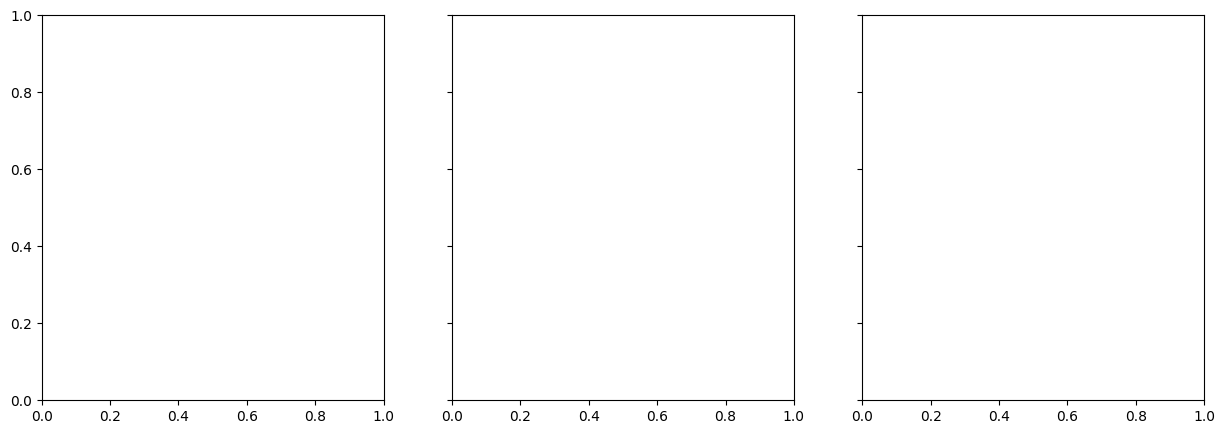

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- assumes _merge_speed_from_roots(base_dirs, lambda, alpha, m0, which="N") exists ----

def plot_speed_heatmaps_separate_cbar(
    *,
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alphas=(1e-3, 1e-2, 1e-1, 1, 10, 1e3, 1e5, 1e8),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e6, 1e8),
    m0_vals=(0.0, 0.5, 1.0),
    which_speed="N",
    cmap="viridis",
    n_levels=40,               # more levels => smoother shading
    add_contours=True,         # overlay thin contour lines
    n_contours=10,
    save=False,
    outpath="speed_heatmaps_sep_cbar.png",
    warn_missing=True
):
    """
    Plot one row of heatmaps: x=λ, y=α, colour=c(λ,α). Each panel is a different m0,
    with its own colourbar (local scaling).
    """
    # normalize inputs
    if isinstance(base_dirs, (str, Path)):
        base_dirs = (base_dirs,)
    base_dirs = tuple(str(Path(b)) for b in base_dirs)
    alphas  = np.asarray(alphas, float)
    lambdas = np.asarray(lambda_vals, float)

    fig, axes = plt.subplots(1, len(m0_vals), figsize=(5*len(m0_vals), 5), sharey=True)
    if len(m0_vals) == 1:
        axes = [axes]

    for ax, m0 in zip(axes, m0_vals):
        # build speed grid C(α_i, λ_j)
        A, L = len(alphas), len(lambdas)
        C = np.full((A, L), np.nan, float)
        miss = 0
        for i, a in enumerate(alphas):
            for j, lam in enumerate(lambdas):
                cval = _merge_speed_from_roots(base_dirs, float(lam), float(a), float(m0), which=which_speed)
                C[i, j] = cval
                if warn_missing and not np.isfinite(cval):
                    miss += 1
        if warn_missing and miss:
            print(f"[info] missing/NaN entries for m0={m0:g}: {miss}")

        X, Y = np.meshgrid(lambdas, alphas)

        # smooth colour shading
        im = ax.contourf(X, Y, C, levels=n_levels, cmap=cmap)
        ax.set_xscale("log"); ax.set_yscale("log")
        ax.set_xlabel(r"$\lambda$")
        ax.set_title(rf"$m_0={m0:g}$")
        ax.grid(True, which="both", alpha=0.2)

        # per-panel colourbar
        cbar = fig.colorbar(im, ax=ax, shrink=0.85, pad=0.02)
        cbar.set_label("Estimated wave speed")

        # optional contour lines over the shading
        if add_contours:
            try:
                cs = ax.contour(X, Y, C, levels=n_contours, colors="k", linewidths=0.6, alpha=0.6)
                ax.clabel(cs, inline=True, fontsize=8, fmt="%.2f")
            except Exception as e:
                print(f"[warn] contour overlay failed for m0={m0:g}: {e}")

    axes[0].set_ylabel(r"$\alpha$")
    fig.suptitle("Wave speed across (λ, α) for different $m_0$", fontsize=15)
    fig.tight_layout(rect=[0, 0, 0.95, 0.94])

    if save:
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved {outpath}")
    else:
        plt.show()


# =========================
# Ready-to-run example call
# =========================
plot_speed_heatmaps_separate_cbar(
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alphas=(1e-3, 1e-2, 1e-1, 1, 10, 1e3, 1e5, 1e8),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e6, 1e8),
    m0_vals=(0.1, 0.5, 1),
    which_speed="N",
    cmap="viridis",        # try "viridis", "magma", "cividis" as alternatives
    n_levels=100,          # increase for even smoother shading
    add_contours=True,
    n_contours=12,
    save=False            # set True to save instead of show
)